# Import packages

In [10]:
import os
import json
import numpy as np
from sympy import symbols, sympify, lambdify
from tabulate import tabulate
import yaml
from datetime import datetime
import glob
import matplotlib.pyplot as plt

import tensorflow as tf

tf.keras.backend.set_floatx('float64')

from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


# Set random seeds for reproducibility
seed_value = 2023
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# Set random seed for GPU (if using TensorFlow with GPU)
if tf.test.is_gpu_available():
    tf.config.experimental.random_seed(seed_value)


## Allow to print actual tf values
# tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)

# Constants and parameters

In [11]:
tf_precision = tf.float64
np_precision = np.float64

with open('config_run.yml', 'r') as ymlfile:
    config_data = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [12]:
problem_name = config_data['problem_folder']
EQS_FILE = problem_name + '.json'
EQS_PATH = os.path.join(os.getcwd(), problem_name, EQS_FILE)

training_steps = config_data['epochs']
display_step = training_steps // 20

load_initial_estimate = config_data['load_initial_estimate']
save_best_solution = config_data['save_best_solution']

lambda_regularization = float(config_data['lambda_regularization'])

if len(list(config_data['learning_rate'].keys())) > 1:
    lr_steps = [int(training_steps * key / 100) for key in list(config_data['learning_rate'].keys()) if key != 0]
    lr_values = [float(val) for val in list(config_data['learning_rate'].values())]
    learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(lr_steps, lr_values)
else:
    learning_rate = float(list(config_data['learning_rate'].values())[0])

In [13]:
# Read the JSON data from the file
with open(EQS_PATH, 'r') as file:
    data = json.load(file)

variables = data['variables']
equations = data['equations']
# equation_terms = data['equation_terms']

variables_str = ' '.join(variables)
variables_sym = symbols(variables_str)
equations_sym = [sympify(eq) for eq in equations]  

## Identify the equation terms
equation_terms = []
for (i, eq) in enumerate(equations_sym):
    terms = []
    for term in eq.args:
        terms.append(str(term))
    equation_terms.append(terms)

# Initialize a list to store the coefficients
scalar_coefficients = []
functions = []
bias_coefficients = []

# Loop through the equation terms
for terms in equation_terms:
    bias_coefficients.append(float(terms[0]))
    coefficients = []   
    for term in terms[1:]:
        # Split each term by the first '*'
        term_parts = term.split('*')
        # Extract the scalar coefficient or default to '1'
        scalar_coeff = term_parts[0] if len(term_parts) > 1 and term_parts[0] not in variables else '1.0'
        coefficients.append(float(scalar_coeff))
               
        # Remove first occurrence of scalar coefficient from the term
        func_coeff = term.replace(term_parts[0]+'*', '', 1) if len(term_parts) > 1 and term_parts[0] not in variables else term
        functions.append(func_coeff)
        
    scalar_coefficients.append(coefficients)   
       
functions_sym = [sympify(func) for func in functions]       
        
print(bias_coefficients)
print(scalar_coefficients)
print(functions)
print(functions_sym)
print(equations_sym)

[-1.0, -1.0]
[[1.0, 1.0], [2.0]]
['b_1', 'b_2', 'a_21*b_2']
[b_1, b_2, a_21*b_2]
[b_1 + b_2 - 1, 2*a_21*b_2 - 1]


# Functions

In [14]:
def load_most_recent_estimate(problem_name, prefix="best_estimate"):
    # Find all JSON files with the specified prefix
    pattern = os.path.join(problem_name, f"{prefix}_*.json")
    files = glob.glob(pattern)

    if not files:
        print(f"No files found with prefix '{prefix}'")
        return None

    # Get the most recent file based on modification time
    most_recent_file = max(files, key=os.path.getmtime)
    
    print(f"Loading most recent estimate from {most_recent_file}")

    # Load json file with initial estimate (best from the most recent run)
    with open(most_recent_file, 'r') as file:
        data = json.load(file)

    return data['best_solution']


@tf.autograph.experimental.do_not_convert
def evaluate_tf_function(inputs, values, symbolic_function):
    # Ensure that the number of inputs and values match
    if len(inputs) != len(values):
        raise ValueError("Number of inputs and values must match.")

    # Evaluate the symbolic function using TensorFlow and the provided values
    result = symbolic_function(*values)
    # Convert the result to a TensorFlow tensor
    result = tf.convert_to_tensor(result, dtype=tf_precision)
    
    # print(result.__class__)
    
    return result


# Create model
@tf.autograph.experimental.do_not_convert
def mlp_model(num_outputs, hidden_layers = [16, 16]):

    # # Reshape input if necessary, matching the shape of the first layer's weights
    # x = tf.reshape(x, [1, -1])  # Adjust the shape as needed
    
    mlp_input = Input(shape=(1,1), name="mlp_input")
    
    hidden_layer = mlp_input
    
    for li, layer_size in enumerate(hidden_layers):
        hidden_layer = Dense(layer_size, activation='tanh', name=f"hidden_layer_{li+1}")(hidden_layer)

    output_layer = Dense(num_outputs, activation='linear', name="output_layer")(hidden_layer)
    
    return Model(inputs=mlp_input, outputs=output_layer)


@tf.autograph.experimental.do_not_convert
def customMSE(vars=variables_sym, funcs=equations_sym, lambda_reg=0.01):
    
    def mse(y_true, y_pred):
        
        y_pred_values = y_pred[0, 0, :]
        
        var_vals = [tf.squeeze(y_pred[0, 0, i]) for i in range(y_pred_values.shape[0])]
        
        nn_residual = list()
        for func in funcs:
            # print(f"func = {func}")
            func_tf = lambdify(vars, func, 'tensorflow')
            nn_residual.append(evaluate_tf_function(variables_sym, var_vals, func_tf))
        
        nn_residual_tf = tf.convert_to_tensor(nn_residual, dtype=tf_precision)

        mse_value = tf.reduce_mean(tf.square(nn_residual_tf))
        
        # Add regularization so the output is not all zeros
        nn_output = y_pred[0, 0, :]
        reg_value = tf.reduce_mean(tf.square(nn_output))        
        
        return mse_value * (1.0 - lambda_reg) + reg_value * lambda_reg
        
        # return y_pred

    return mse


# Model

## Create and compile model

In [15]:
# Network Parameters
num_input = 1 # input layer

num_vars = len(variables)
num_output = num_vars

# Create the model
model = mlp_model(num_output, hidden_layers = [64, 64])
model.summary()

# Define the optimizer and loss function
optimizer = Adam(learning_rate=learning_rate)
# optimizer = SGD(learning_rate=learning_rate)
loss_object = customMSE(variables_sym, equations_sym, lambda_reg=lambda_regularization)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_object)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_input (InputLayer)      [(None, 1, 1)]            0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1, 64)             128       
                                                                 
 hidden_layer_2 (Dense)      (None, 1, 64)             4160      
                                                                 
 output_layer (Dense)        (None, 1, 3)              195       
                                                                 
Total params: 4483 (35.02 KB)
Trainable params: 4483 (35.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model

In [16]:
# Create a constant input (e.g., zeros) since the input is supposed to be constant
constant_input = np.ones((1, 1, 1))

# Assuming num_output is the number of output nodes in your model
# You can use a dummy value for y_true since your loss function doesn't depend on it
dummy_y_true = np.zeros((1, num_output))

# Fit the model
history = model.fit(x=constant_input, y=dummy_y_true, 
          epochs=training_steps, 
          batch_size=1,
          verbose=2)

Epoch 1/1001


1/1 - 1s - loss: 0.6692 - 1s/epoch - 1s/step
Epoch 2/1001
1/1 - 0s - loss: 0.5914 - 3ms/epoch - 3ms/step
Epoch 3/1001
1/1 - 0s - loss: 0.5201 - 2ms/epoch - 2ms/step
Epoch 4/1001
1/1 - 0s - loss: 0.4509 - 3ms/epoch - 3ms/step
Epoch 5/1001
1/1 - 0s - loss: 0.3803 - 3ms/epoch - 3ms/step
Epoch 6/1001
1/1 - 0s - loss: 0.3078 - 3ms/epoch - 3ms/step
Epoch 7/1001
1/1 - 0s - loss: 0.2359 - 3ms/epoch - 3ms/step
Epoch 8/1001
1/1 - 0s - loss: 0.1698 - 3ms/epoch - 3ms/step
Epoch 9/1001
1/1 - 0s - loss: 0.1160 - 3ms/epoch - 3ms/step
Epoch 10/1001
1/1 - 0s - loss: 0.0797 - 3ms/epoch - 3ms/step
Epoch 11/1001
1/1 - 0s - loss: 0.0605 - 2ms/epoch - 2ms/step
Epoch 12/1001
1/1 - 0s - loss: 0.0489 - 3ms/epoch - 3ms/step
Epoch 13/1001
1/1 - 0s - loss: 0.0345 - 3ms/epoch - 3ms/step
Epoch 14/1001
1/1 - 0s - loss: 0.0166 - 3ms/epoch - 3ms/step
Epoch 15/1001
1/1 - 0s - loss: 0.0033 - 2ms/epoch - 2ms/step
Epoch 16/1001
1/1 - 0s - loss: 0.0034 - 3ms/epoch - 3ms/step
Epoch 17/1001
1/1 - 0s - loss: 0.0163 - 2ms/epoc

## Plot history

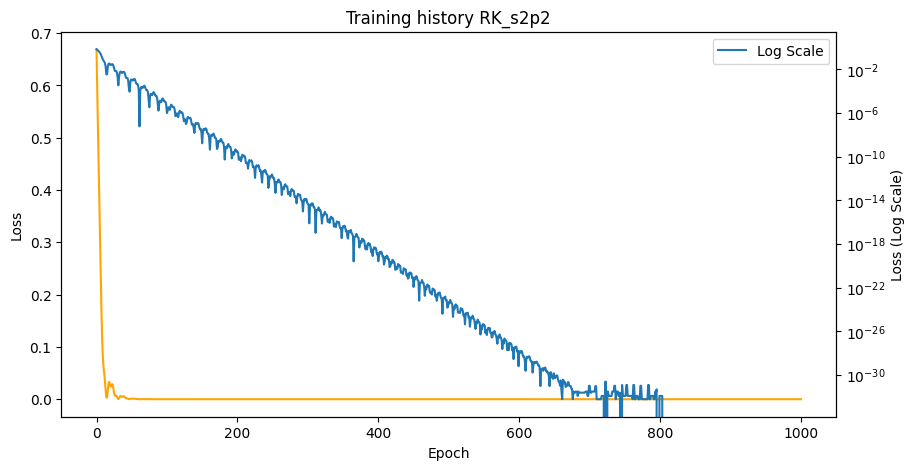

In [17]:
rk_method = problem_name.split('_')[-1]

# Plot training history with log scale (left) and linear scale (right)
plt.figure(figsize=(10, 5))

# Plot on the right side with linear scale
plt.plot(history.history['loss'], color='orange', label='Linear Scale')
plt.title(f'Training history RK_{rk_method}')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Create a secondary y-axis for the right side
plt2 = plt.gca().twinx()
# Plot on the left side with log scale
plt2.semilogy(history.history['loss'], label='Log Scale')
plt2.set_ylabel('Loss (Log Scale)')

# Add legend for both axes
plt.legend(loc='upper left')
plt2.legend(loc='upper right')

# Show the plot
plt.show()

## Test the model

In [18]:
# Test the model
solution = model.predict(constant_input)[0][0]

print('BEST SOLUTION')
for i, var in enumerate(variables):
    print(f'{var:4} = {solution[i]:.16f}')

headers = ['Equation', 'Function residual']
table_data = []
for f, func in enumerate(equations):
    eq = equations_sym[f]
    equation = lambdify(variables_sym, eq)
    func_res_eq = abs(equation(*solution))
    table_data.append([f'{func} = ', f'{func_res_eq:.4e}'])

print(tabulate(table_data, headers=headers, tablefmt='grid'))

1/1 [==============================] - 0s 109ms/step
BEST SOLUTION
a_21 = 1.3481167925064548
b_1  = 0.6291122529002946
b_2  = 0.3708877470997054
+------------------+---------------------+
| Equation         |   Function residual |
+==================+=====================+
| b_1 + b_2 - 1 =  |                   0 |
+------------------+---------------------+
| 2*a_21*b_2 - 1 = |                   0 |
+------------------+---------------------+
